In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import models
import numpy as np
import random  # Required for setting the seed

# Setting seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Directories
base_dir = 'sample_shapes_dataset'
test_base_dir = 'sample_shapes_test_dataset'

# Parameters
img_size = (128, 128)
batch_size = 32
target_size = (224, 224) # this is what VGG was trained on
num_of_classes = 3

# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.12  # reserve 15% of the data for validation
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

# Generate data
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # Use the 70% of data not reserved for validation/test
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Use the first half of 30% data reserved by validation_split (i.e., 15% of total)
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    test_base_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=SEED,
    shuffle=False
)

# Load the VGG16 network, ensuring the head FC layer sets are left off
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*target_size, num_of_classes))

# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Create the model
model = models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_of_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

Found 2244 images belonging to 3 classes.
Found 381 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
Epoch 1/10
70/70 [==============================] - 177s 3s/step - loss: 0.3837 - accuracy: 0.9458 - val_loss: 0.0067 - val_accuracy: 0.9972
Epoch 2/10
70/70 [==============================] - 175s 2s/step - loss: 0.0353 - accuracy: 0.9928 - val_loss: 0.0045 - val_accuracy: 0.9972
Epoch 3/10
70/70 [==============================] - 177s 3s/step - loss: 0.0175 - accuracy: 0.9973 - val_loss: 0.0074 - val_accuracy: 0.9972
Epoch 4/10
70/70 [==============================] - 179s 3s/step - loss: 2.9814 - accuracy: 0.9552 - val_loss: 0.1695 - val_accuracy: 0.9915
Epoch 5/10
70/70 [==============================] - 181s 3s/step - loss: 0.4128 - accuracy: 0.9842 - val_loss: 0.0716 - val_accuracy: 0.9915
Epoch 6/10
70/70 [==============================] - 181s 3s/step - loss: 0.0448 - accuracy: 0.9896 - val_loss: 0.0472 - val_accuracy: 0.9915
Epoch 7/10
70/70 [============

In [5]:
model.save("vgg16_shapes_model.h5")

C:\Users\capek\pycharm_projects\computer_vision_experiments\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 131ms/step


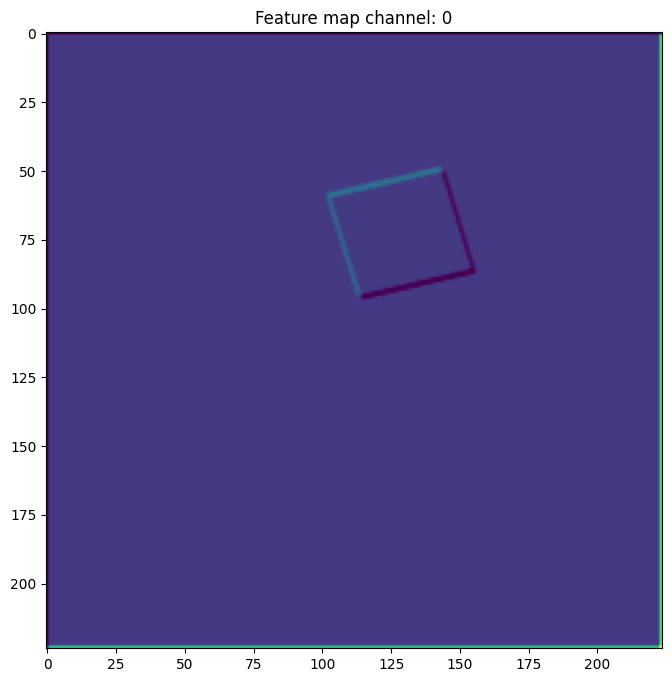

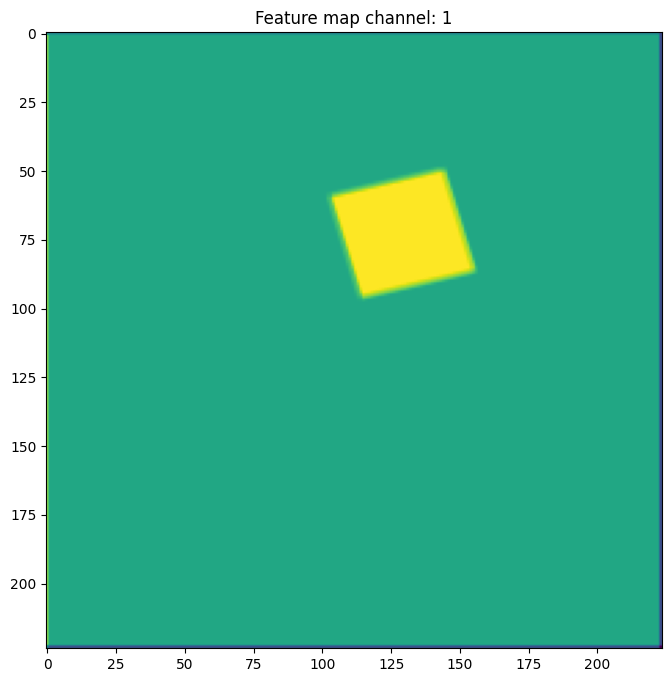

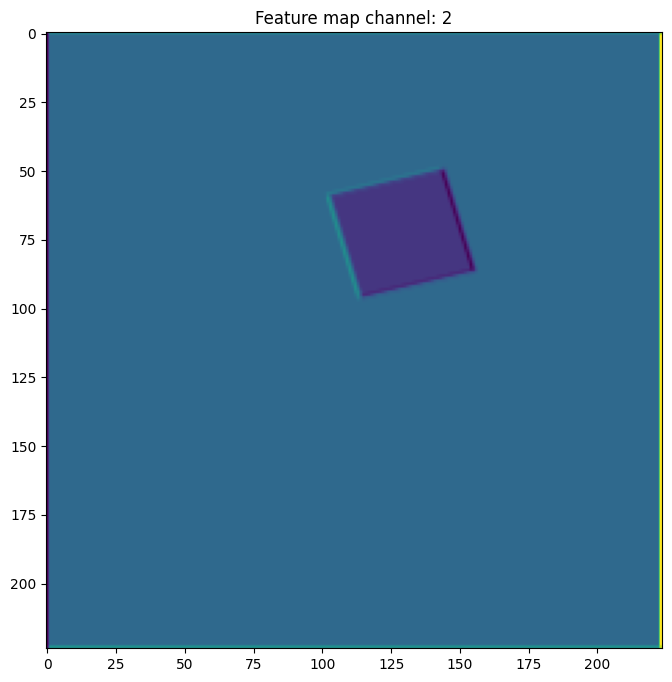

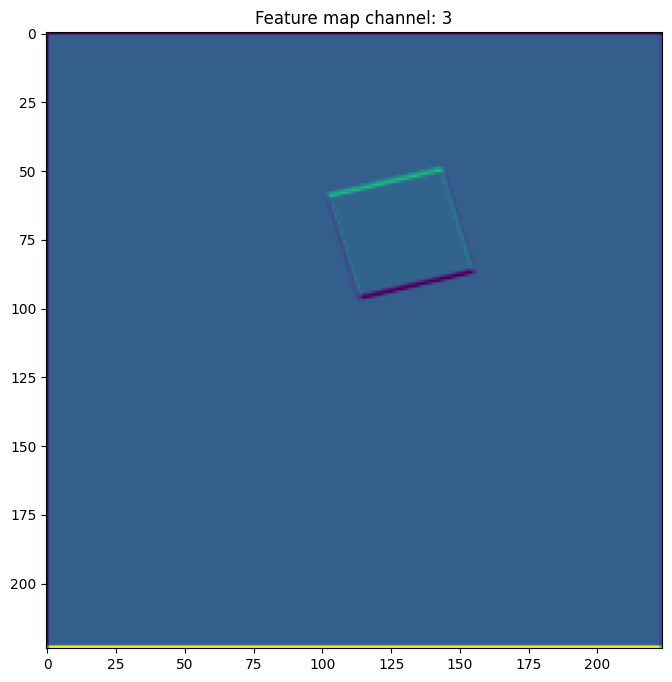

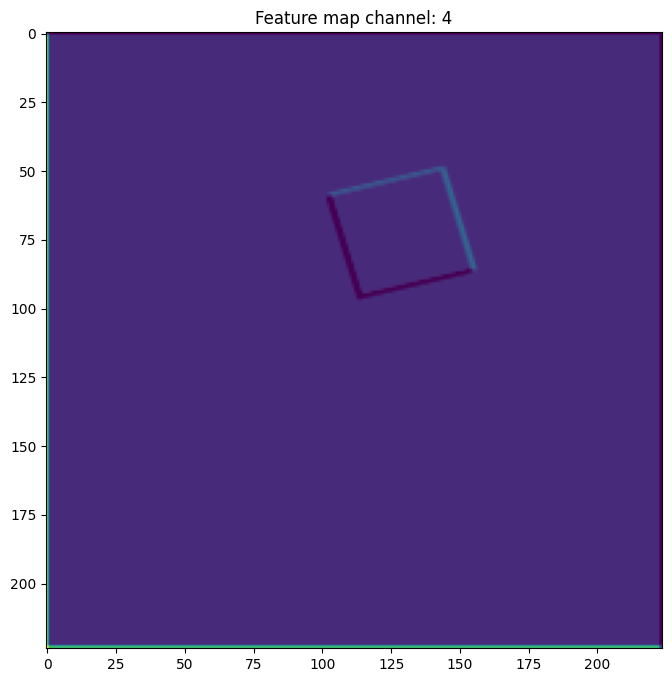

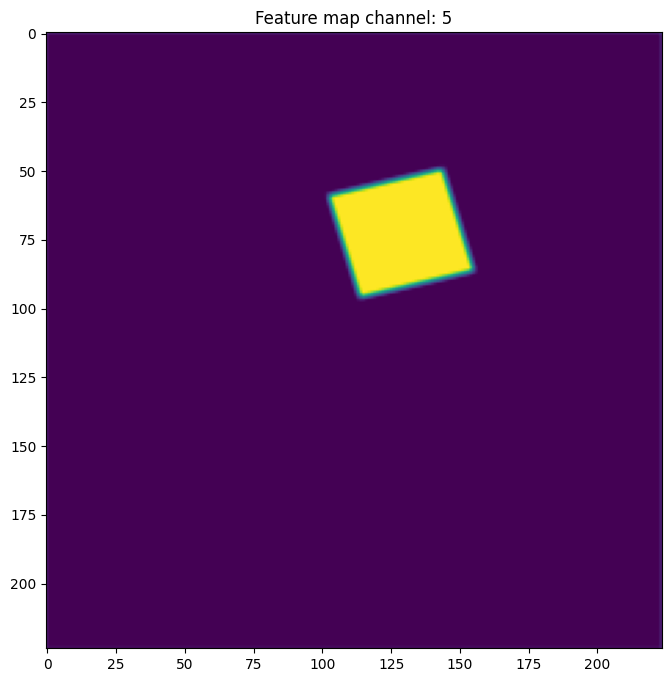

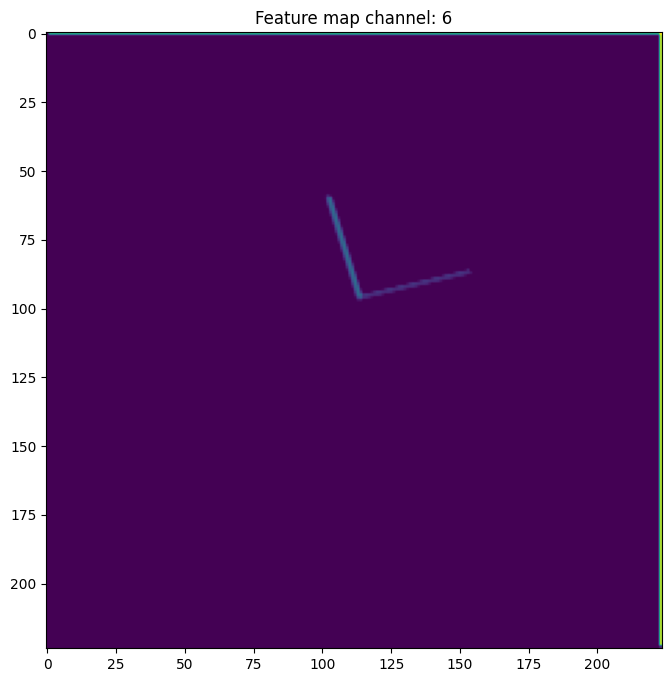

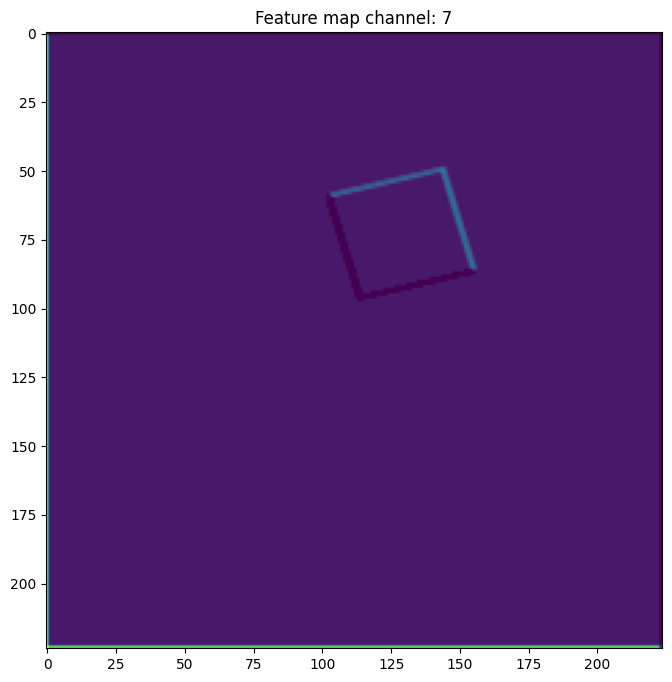

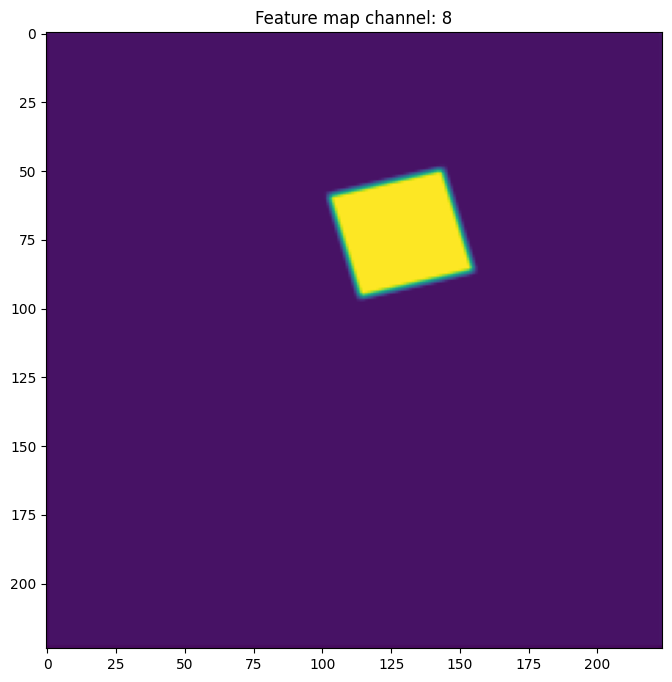

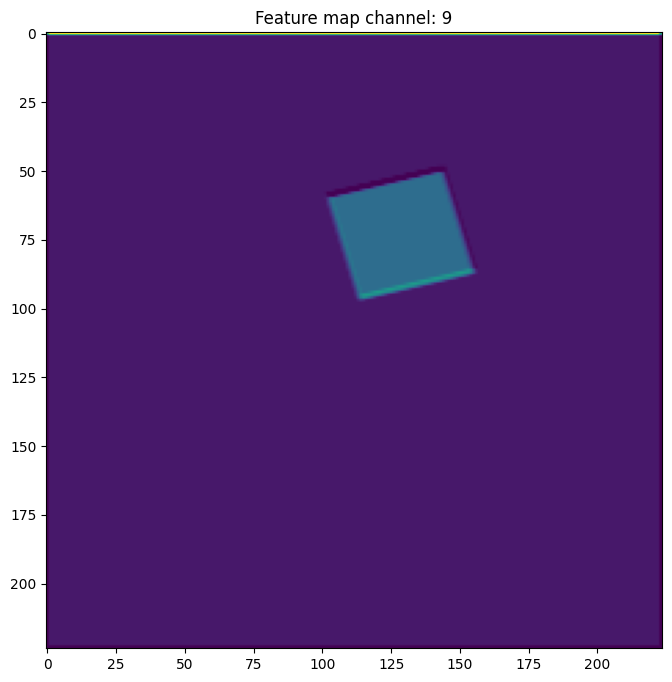

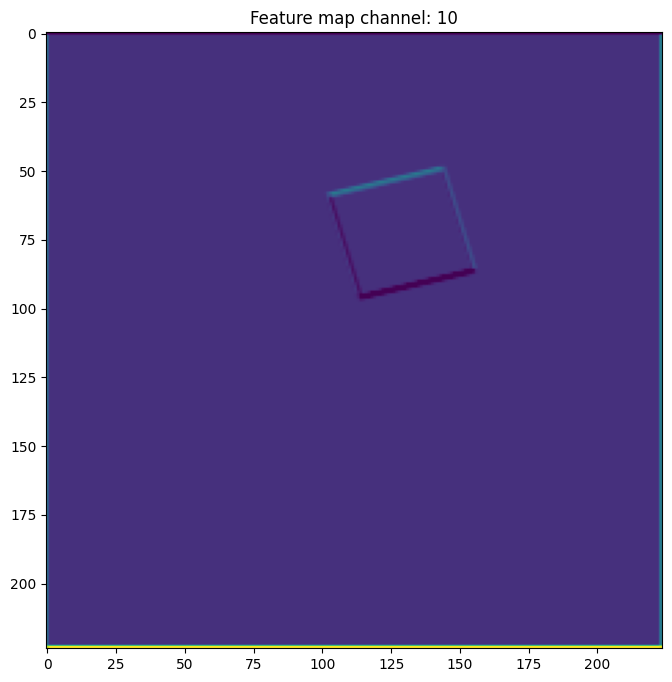

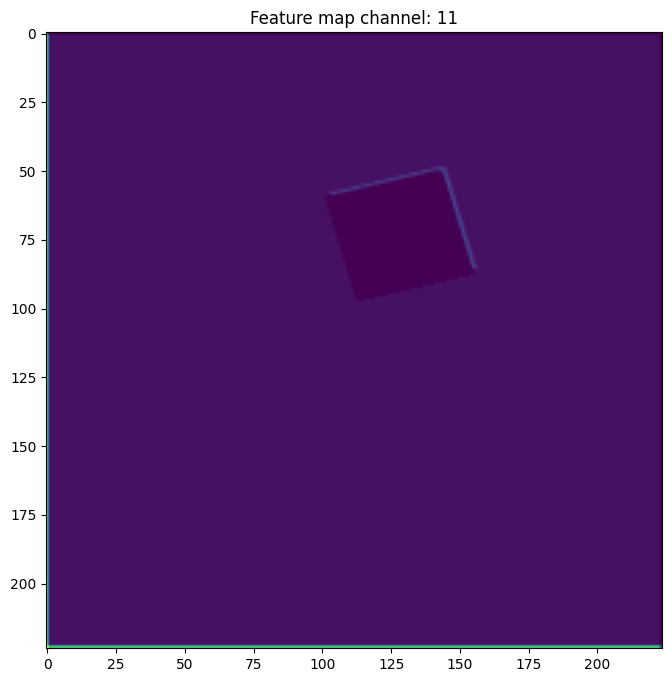

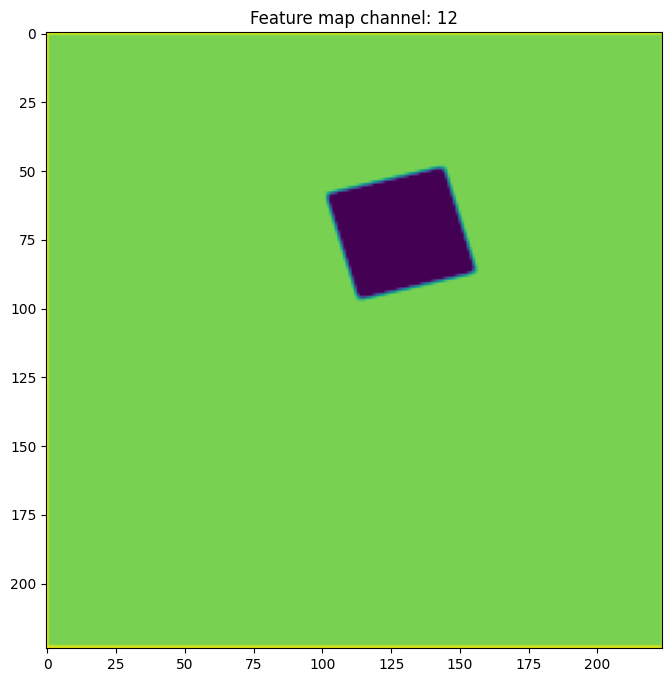

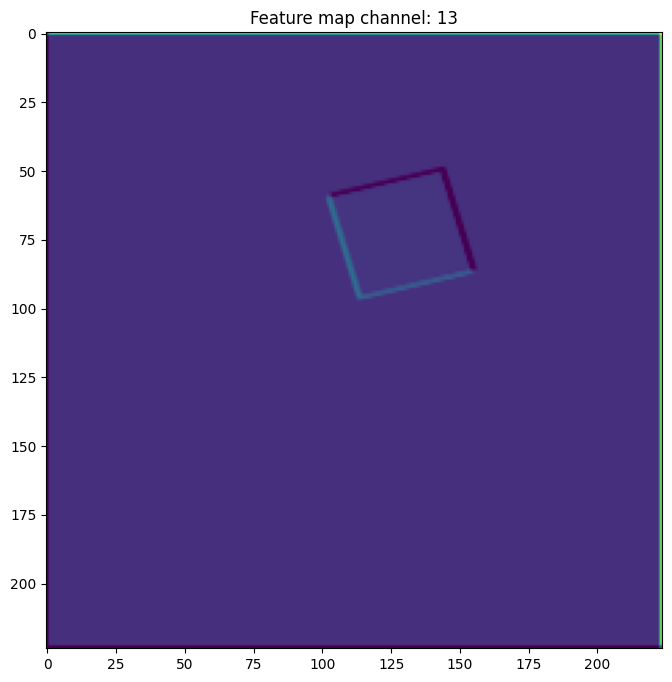

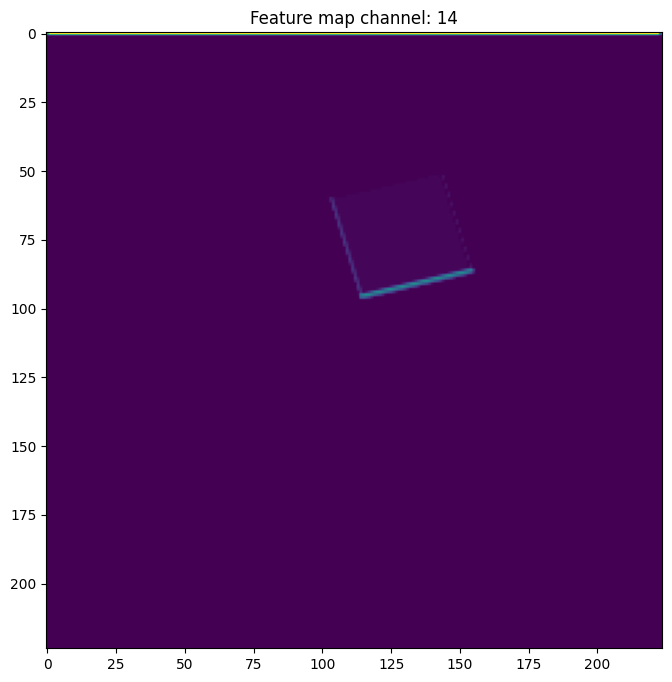

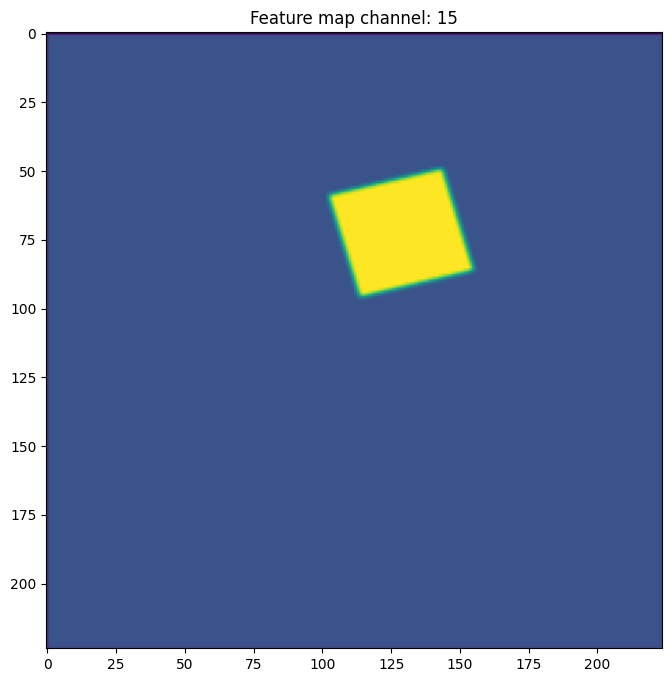

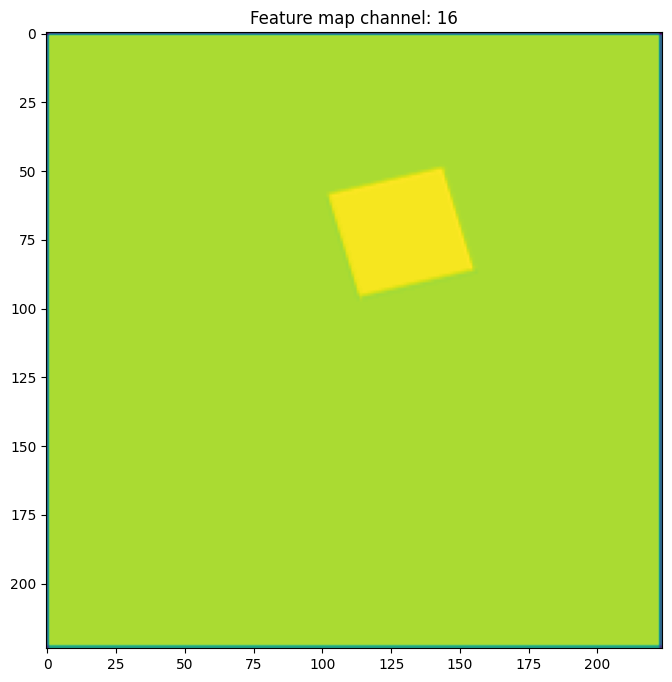

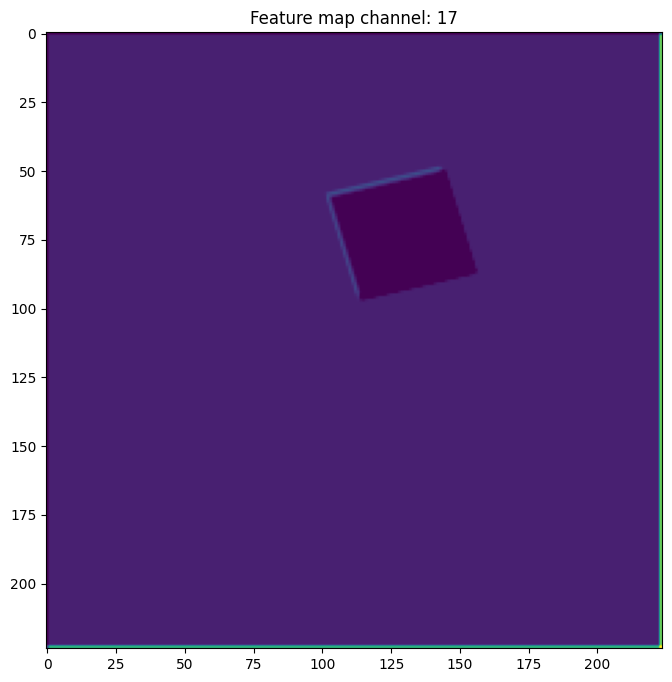

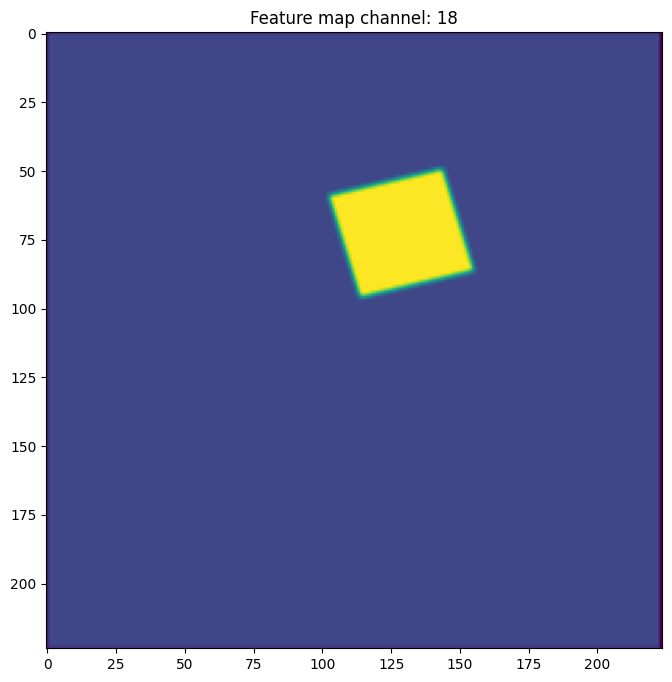

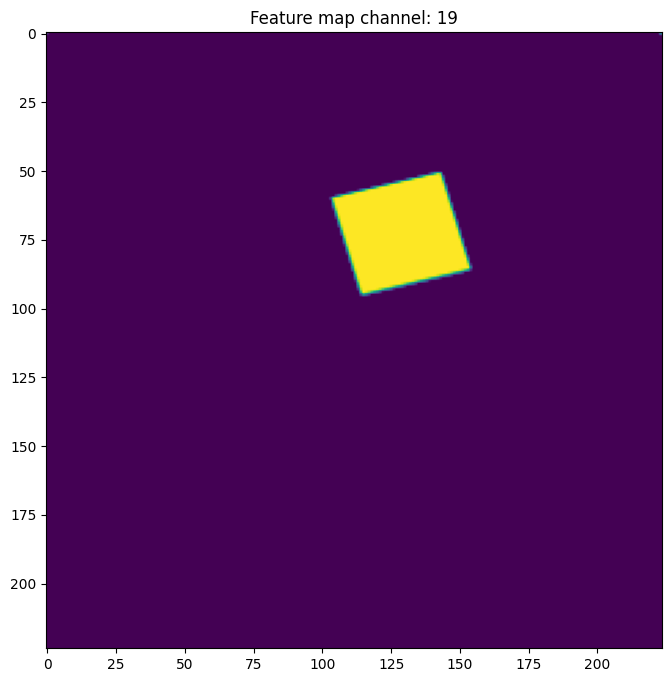

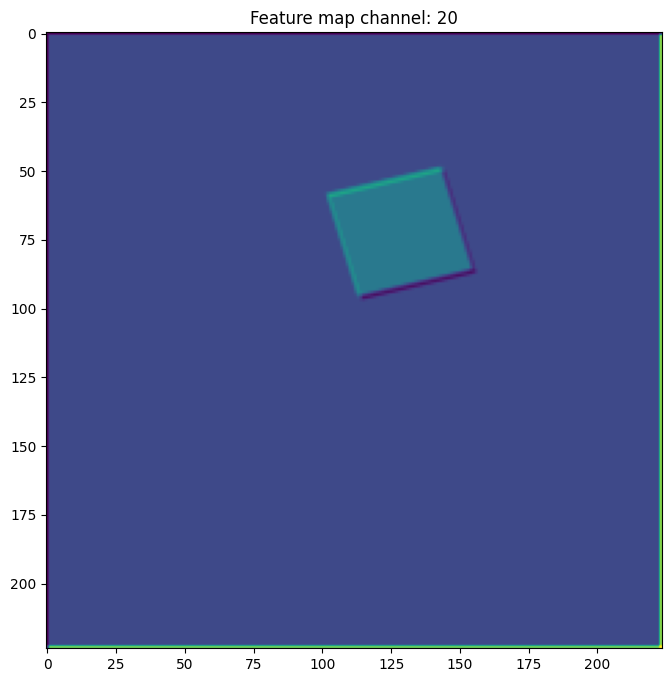

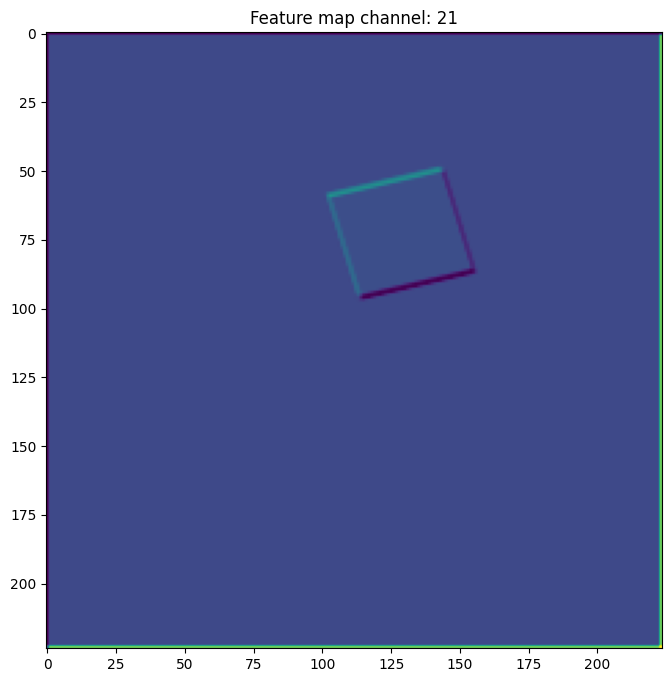

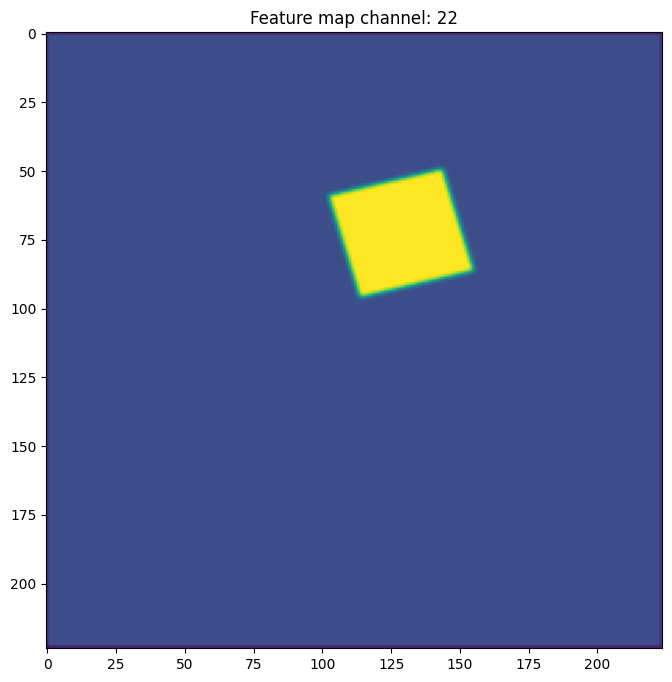

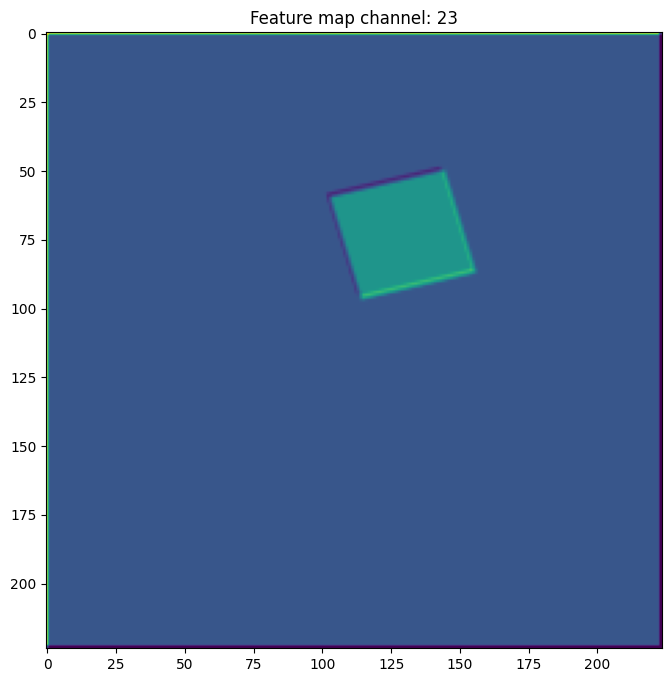

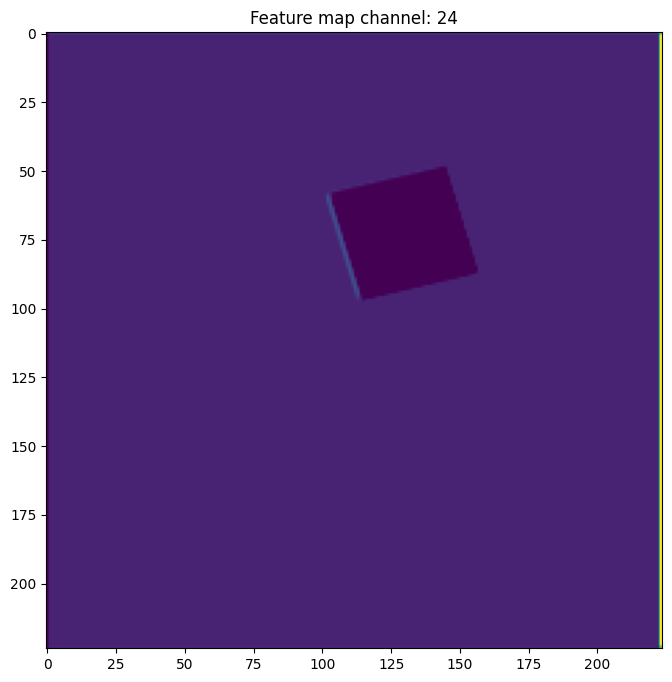

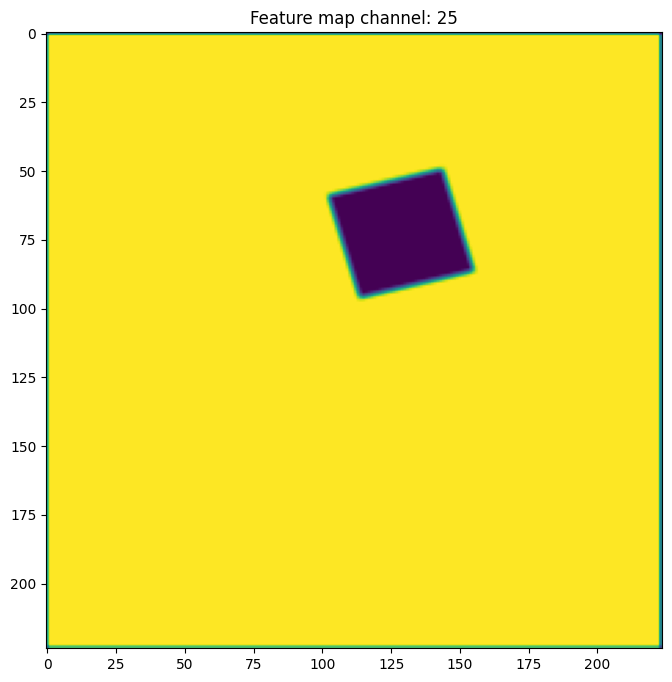

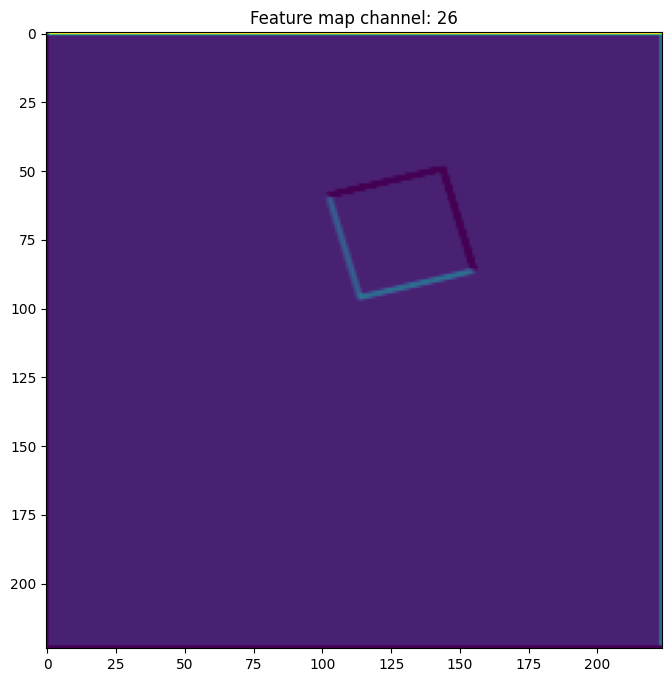

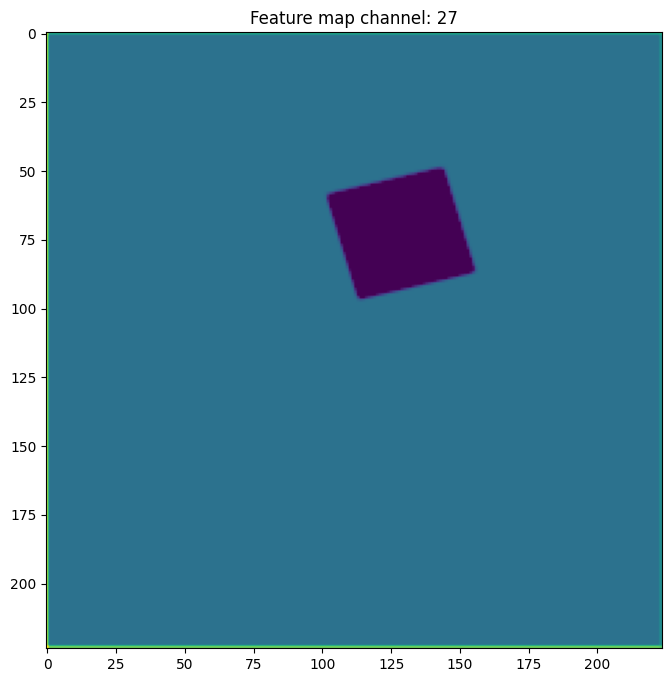

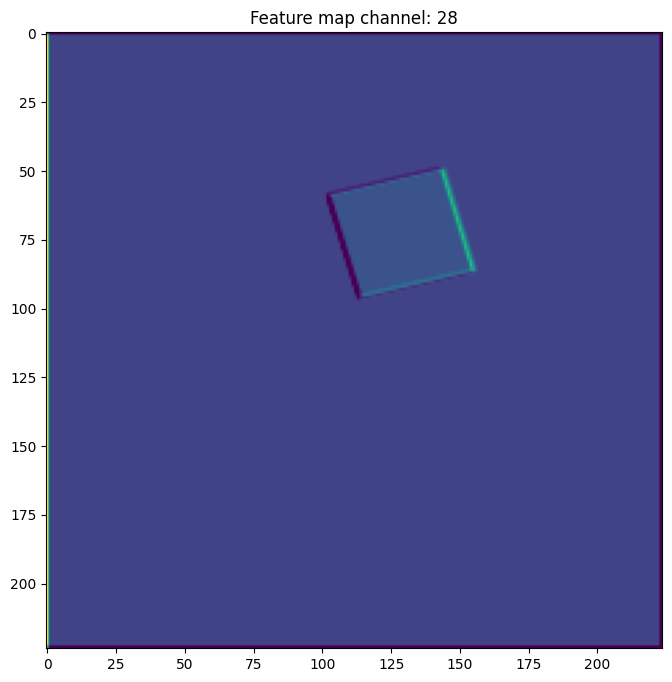

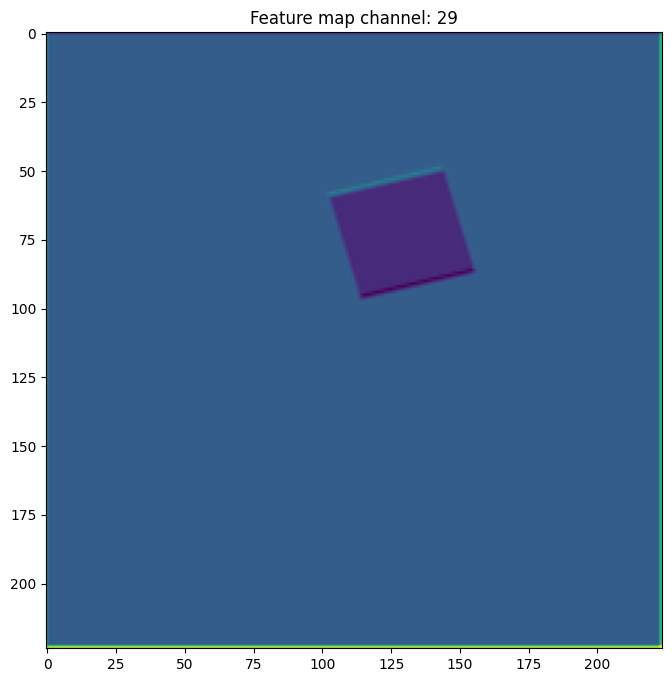

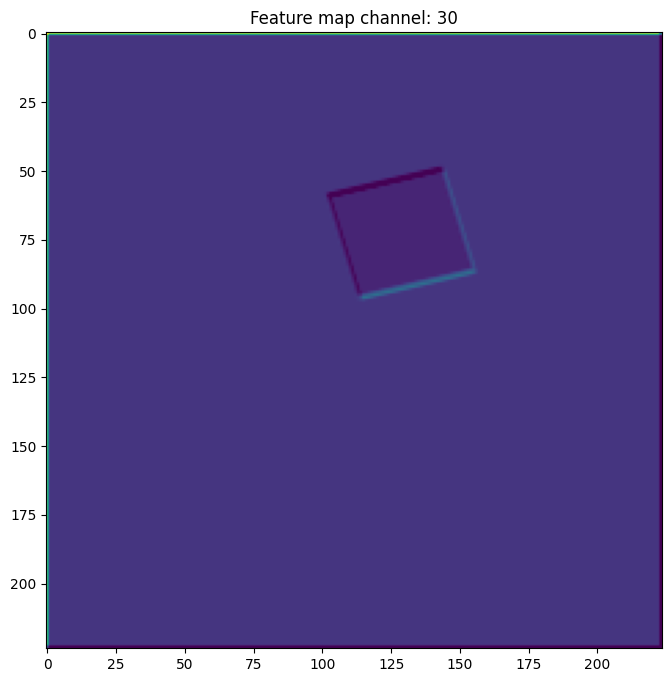

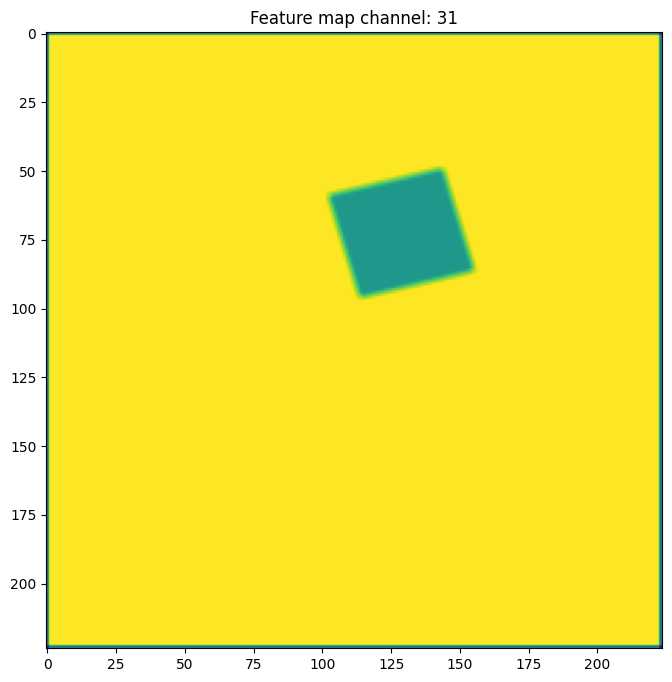

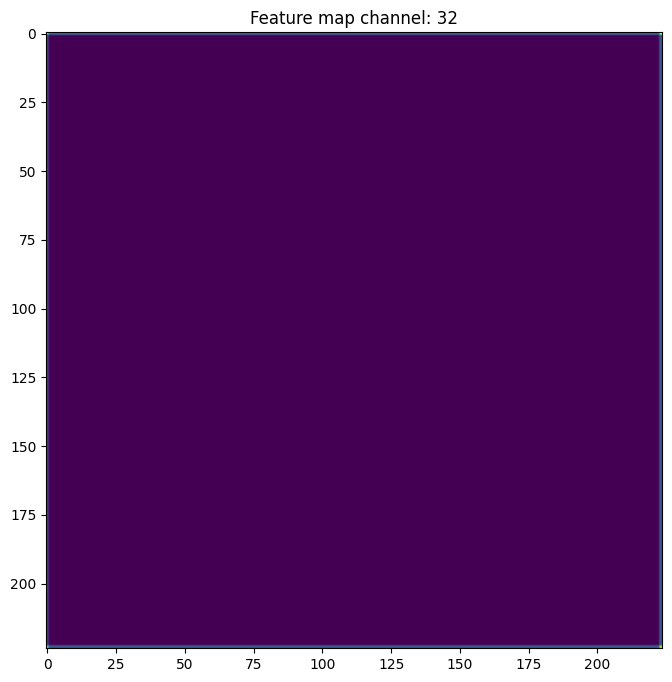

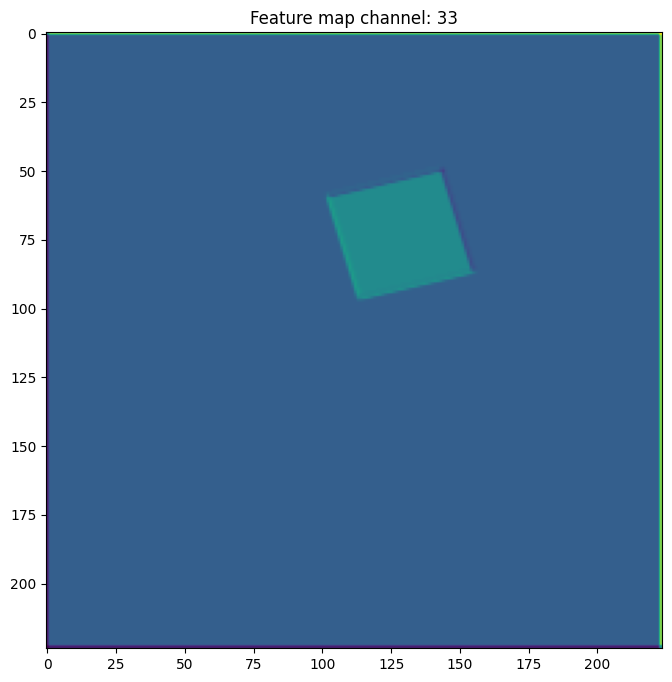

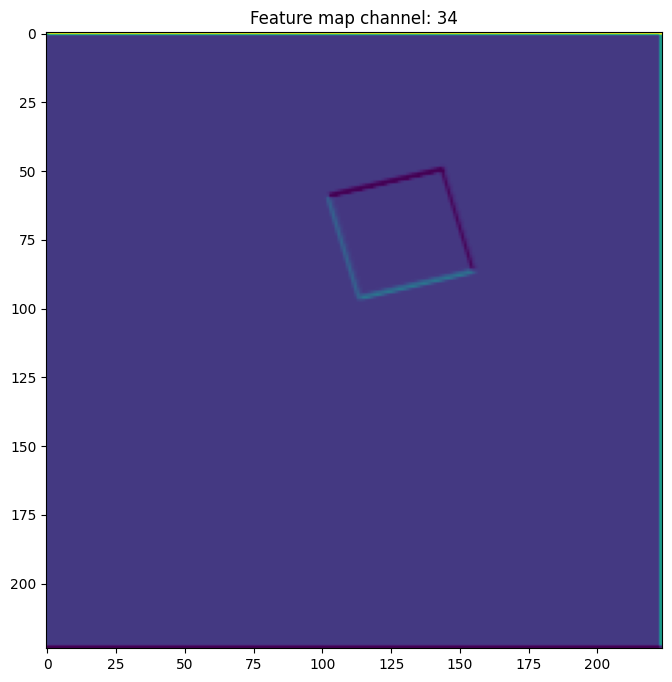

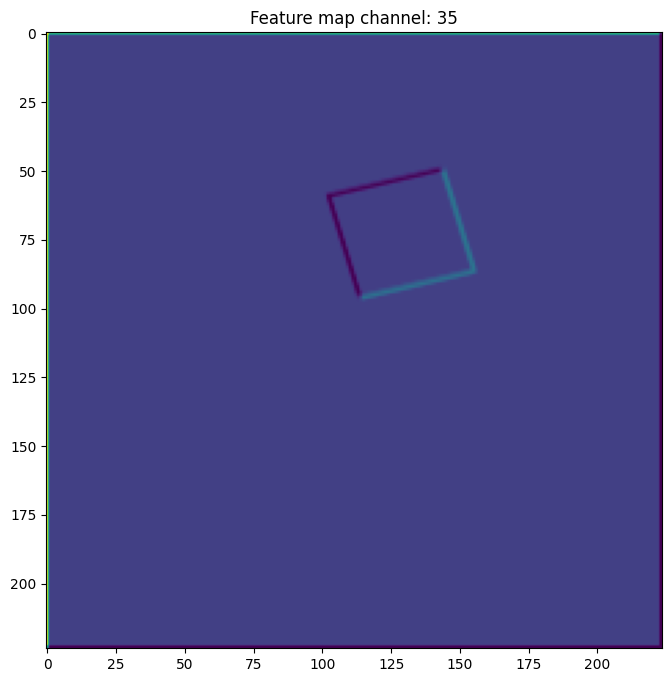

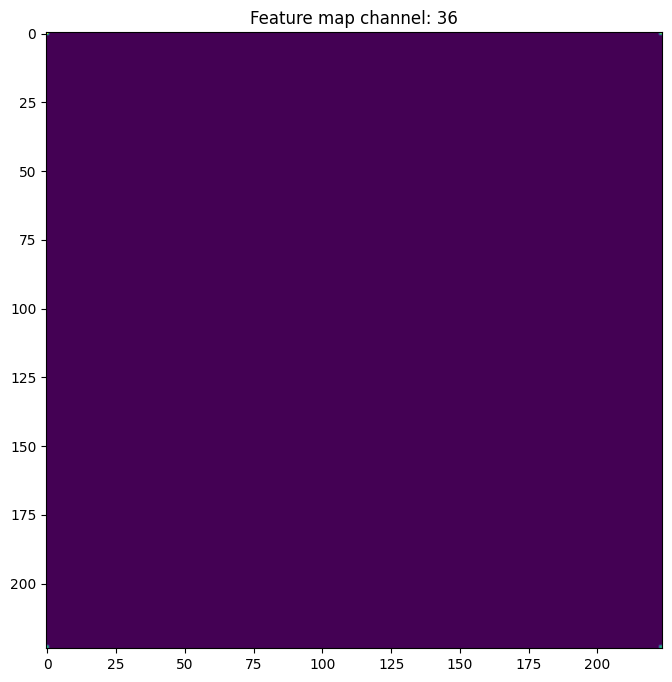

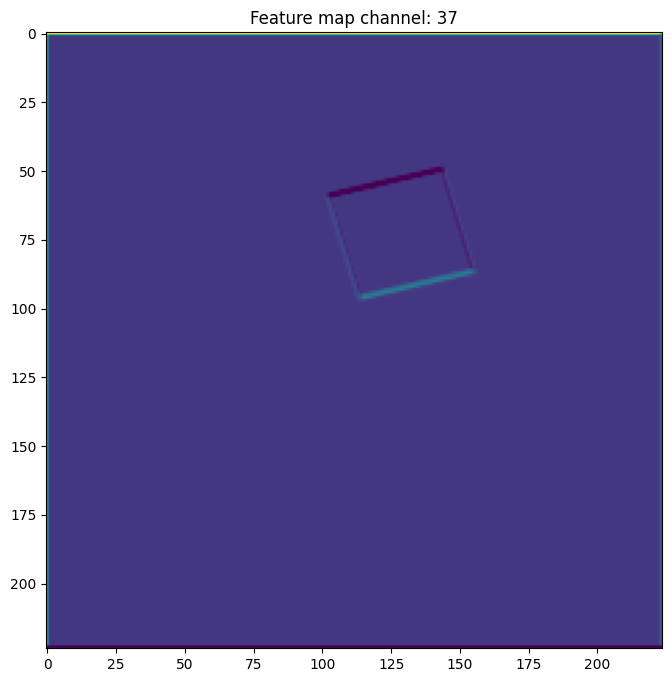

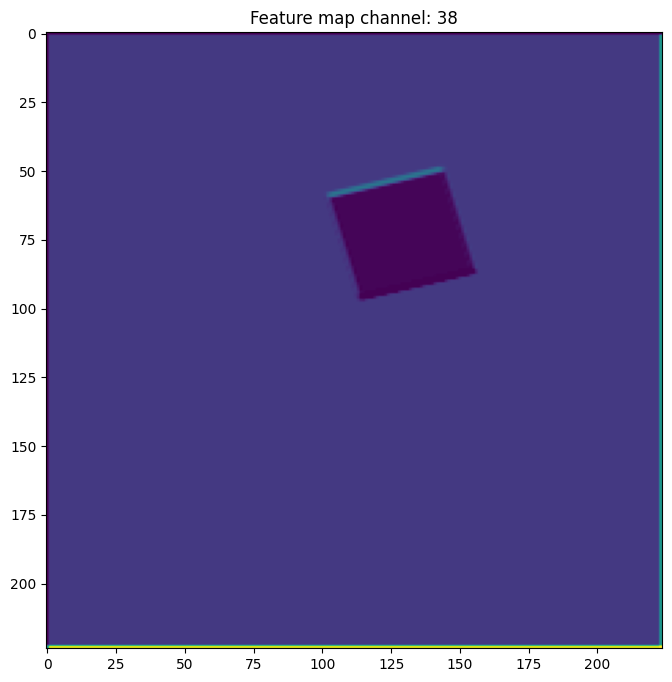

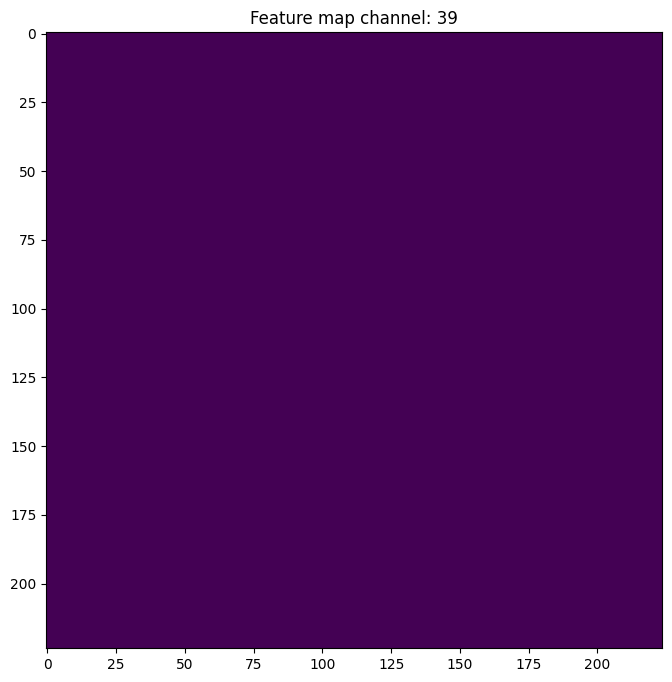

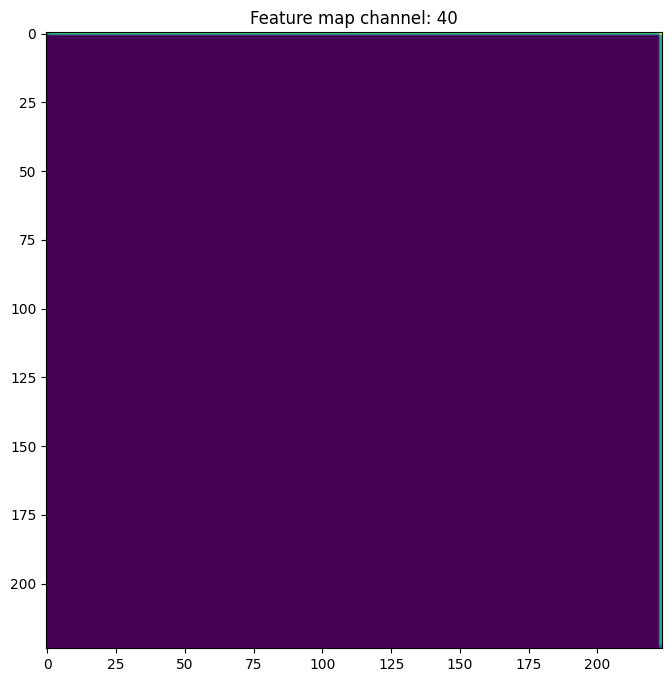

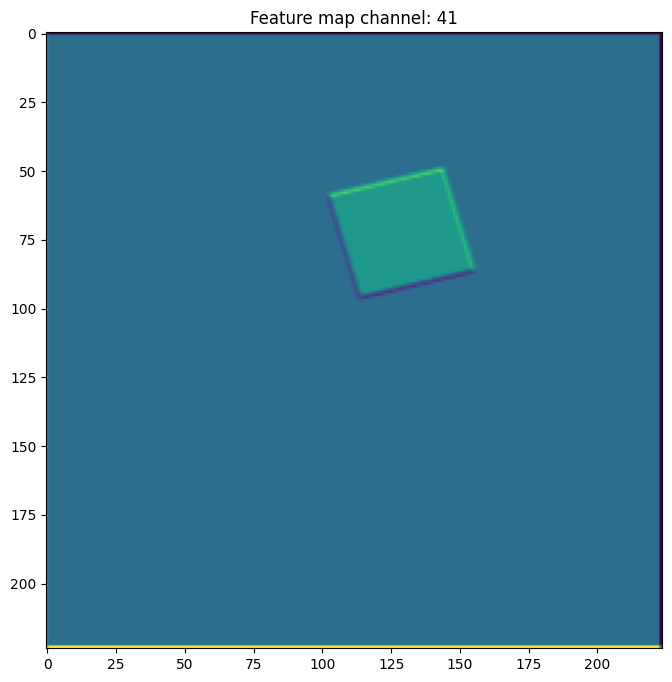

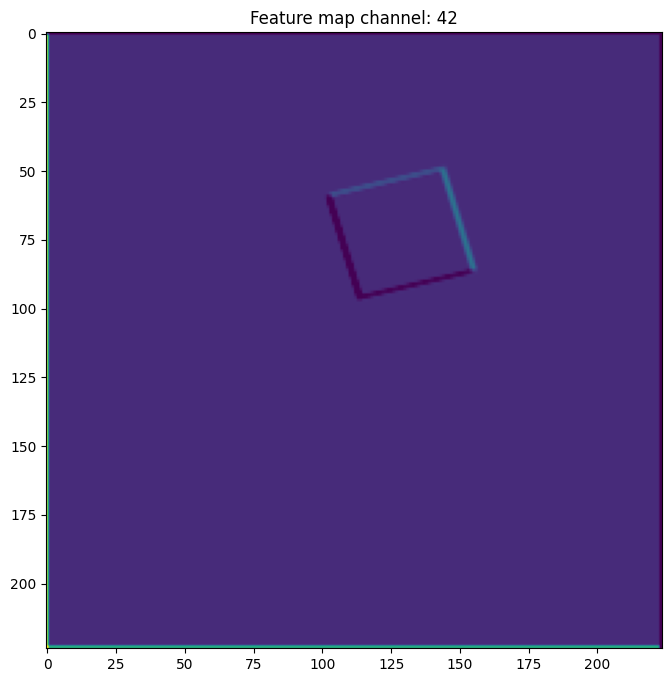

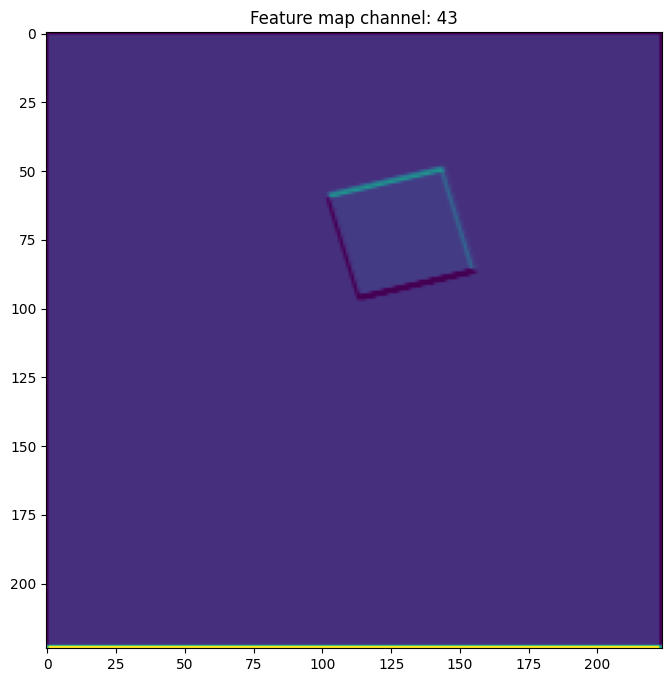

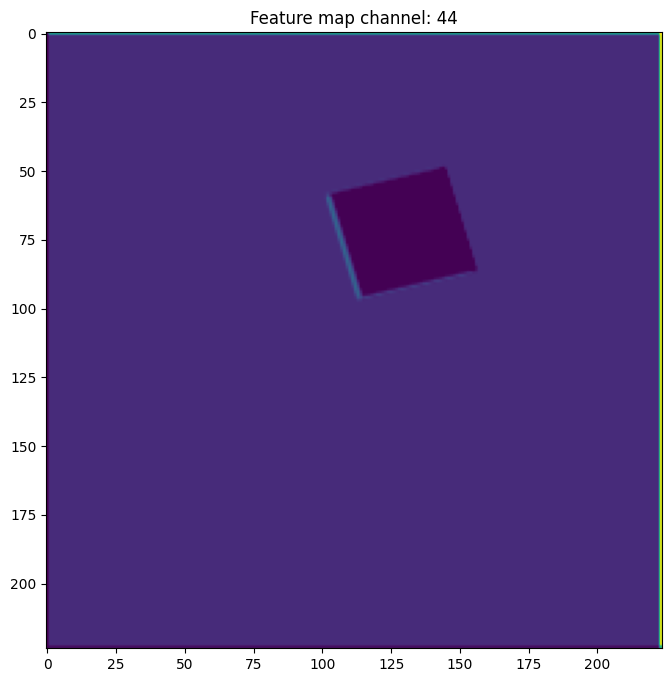

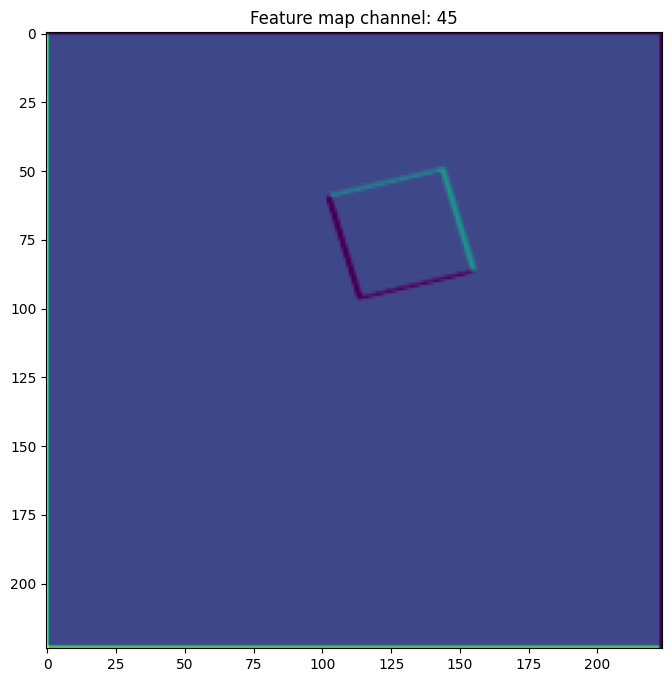

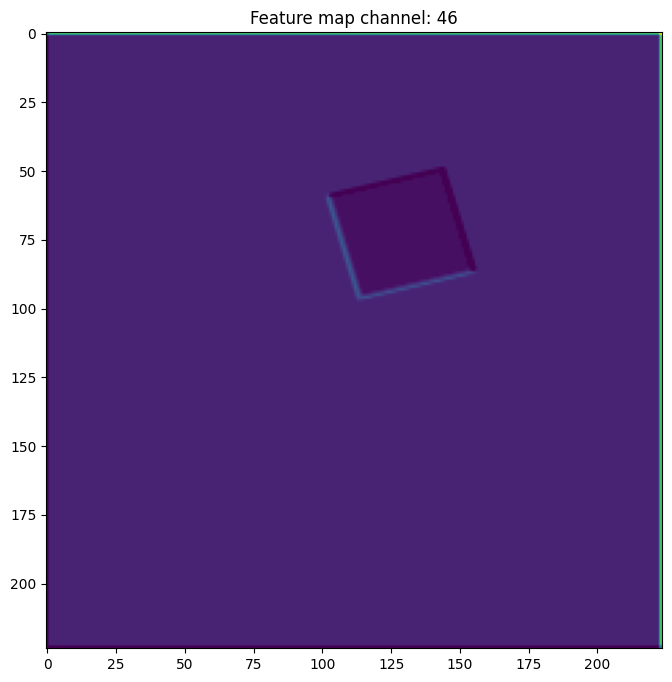

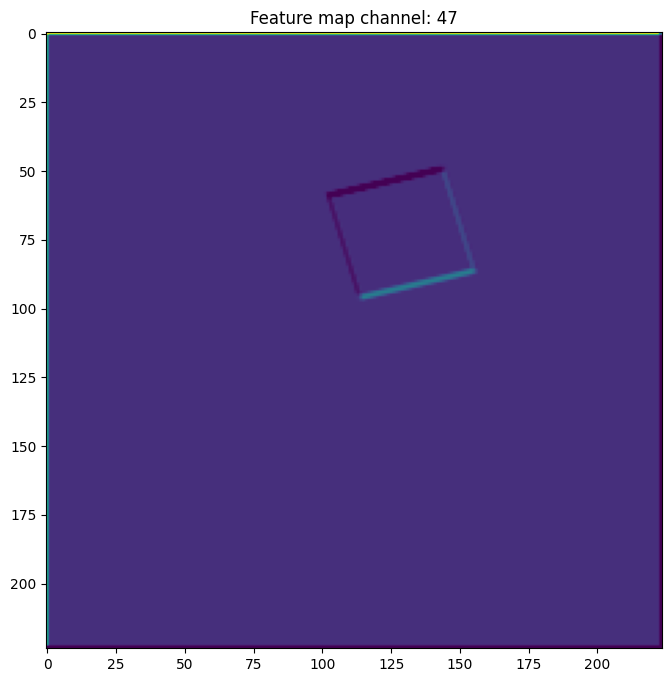

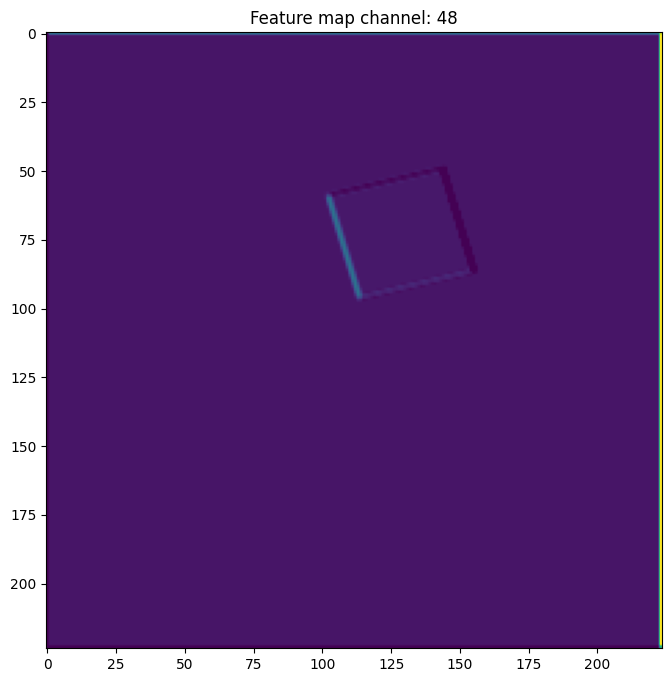

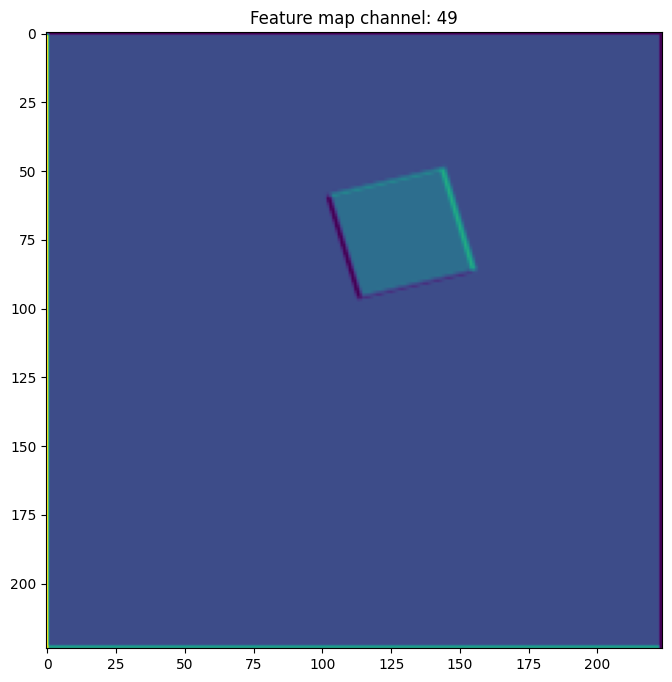

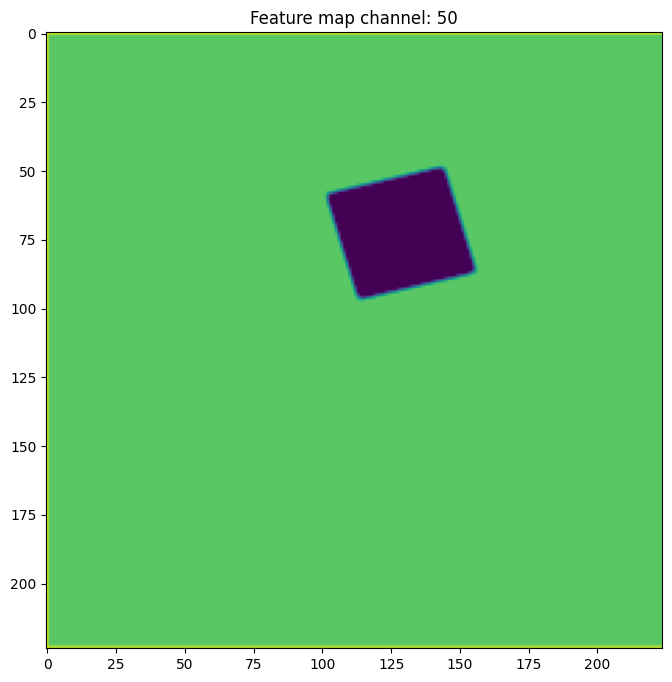

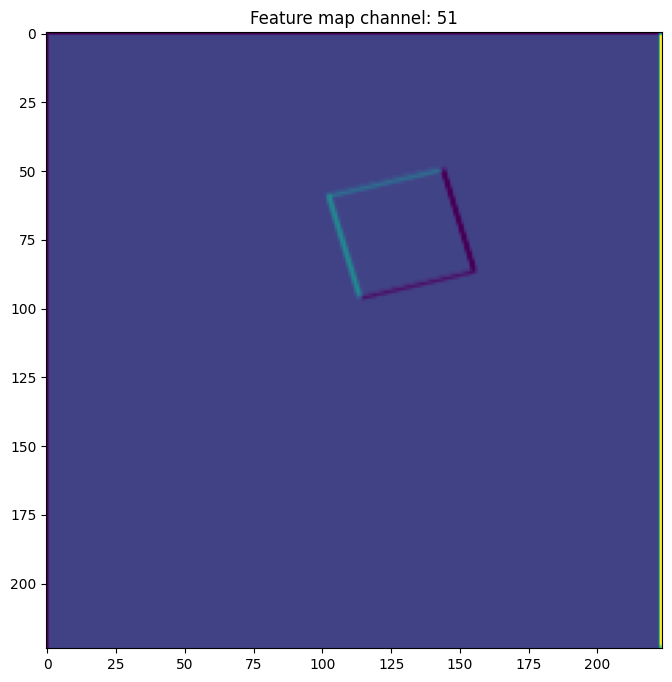

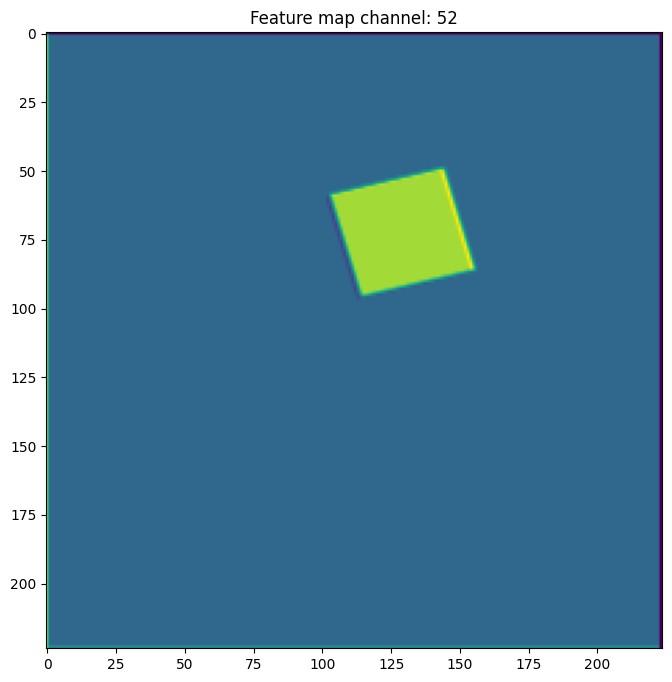

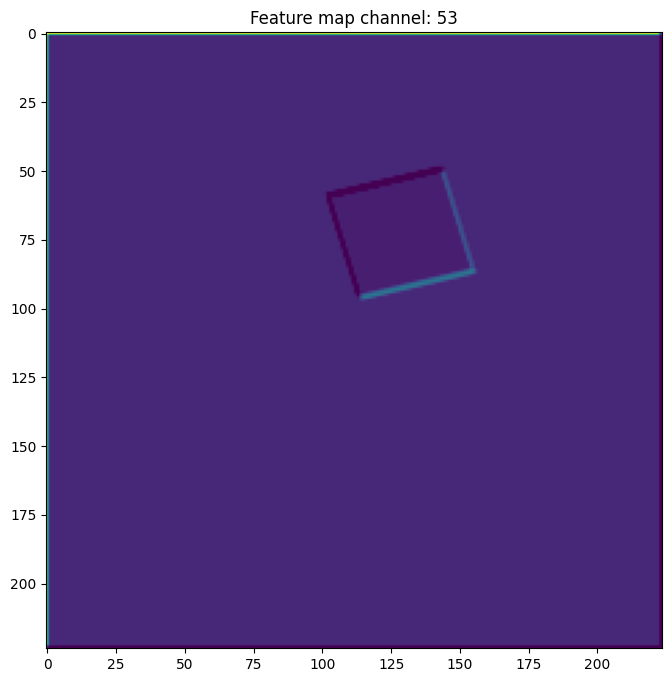

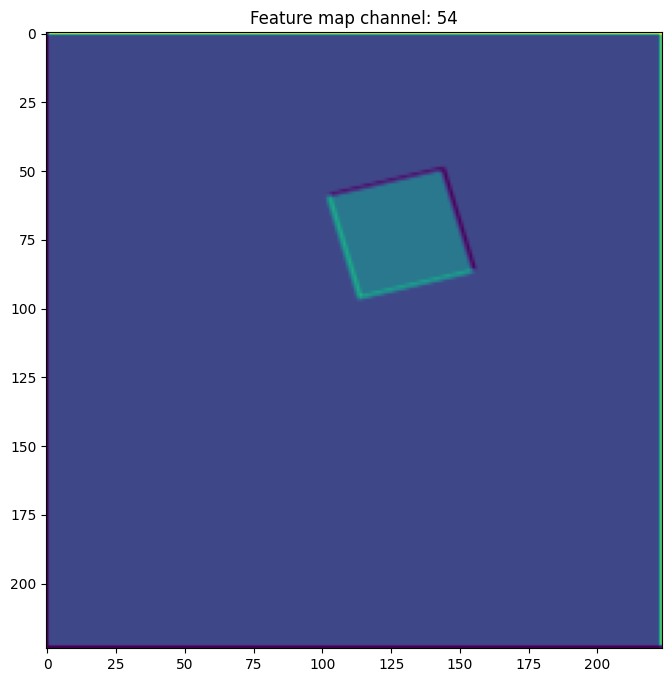

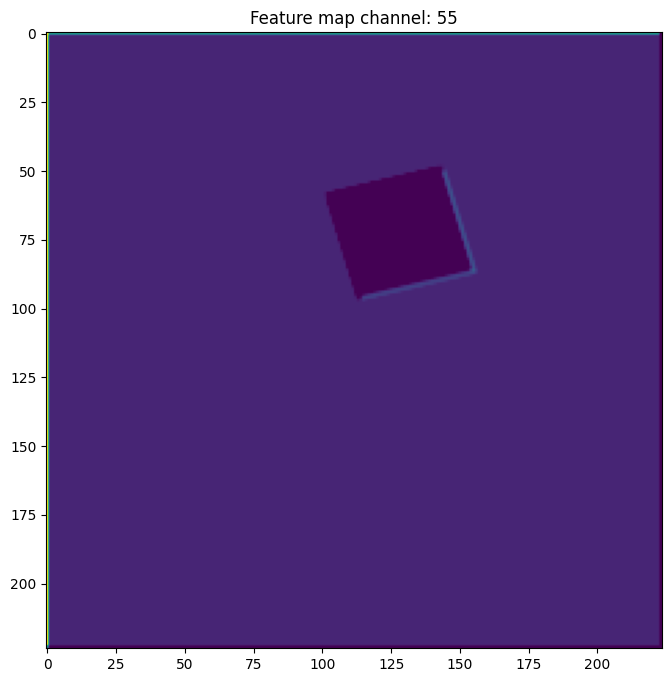

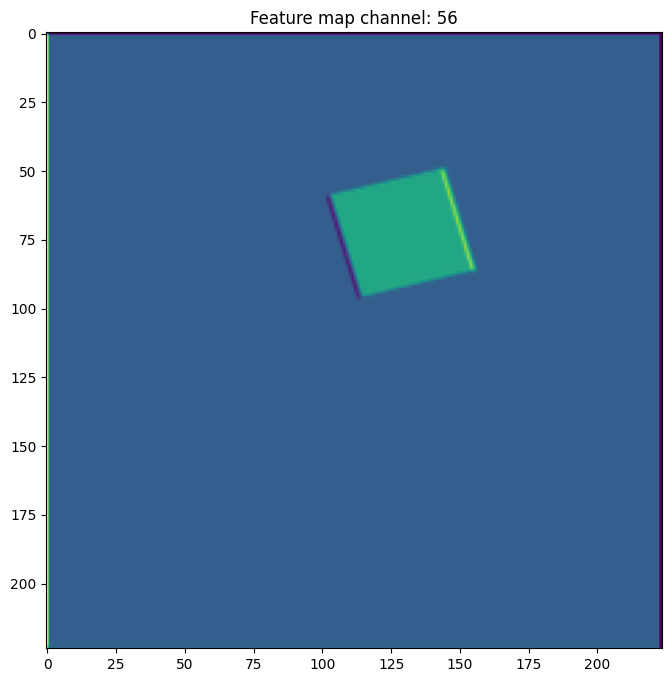

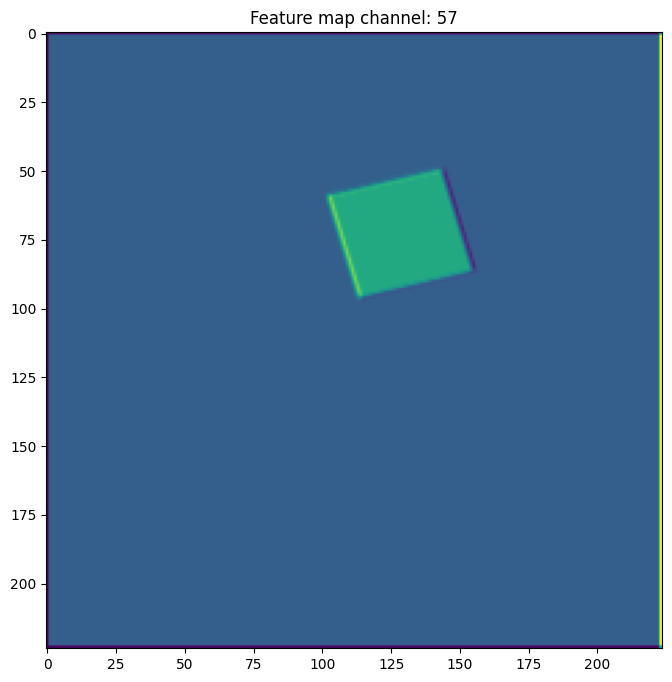

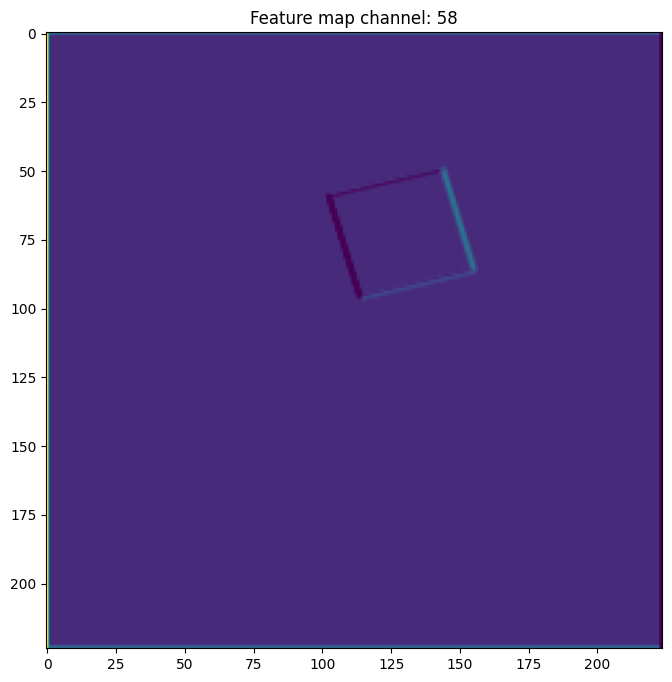

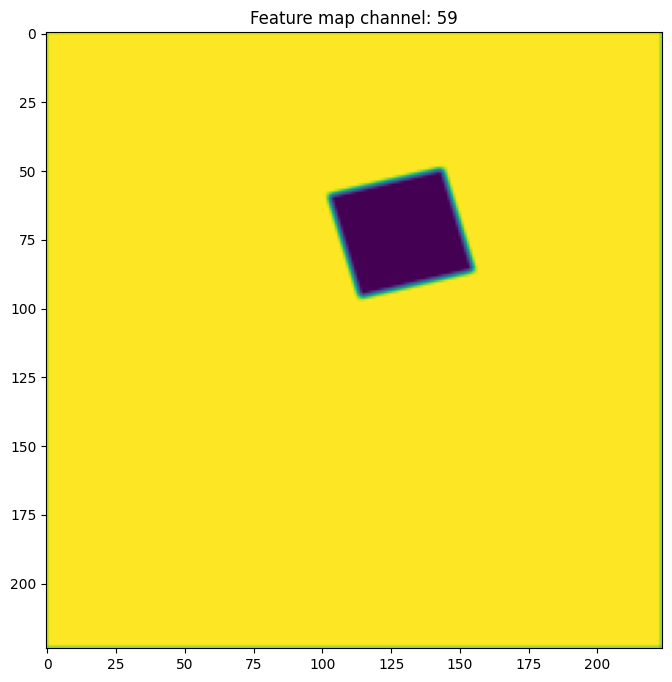

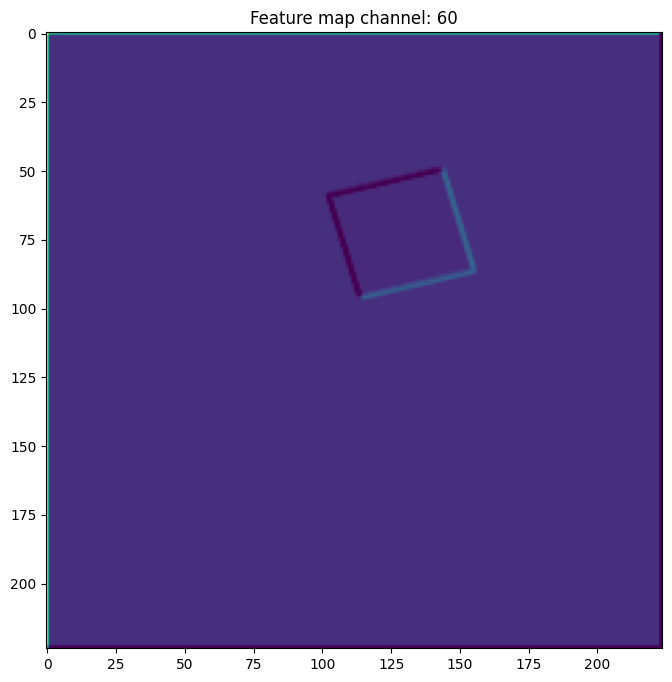

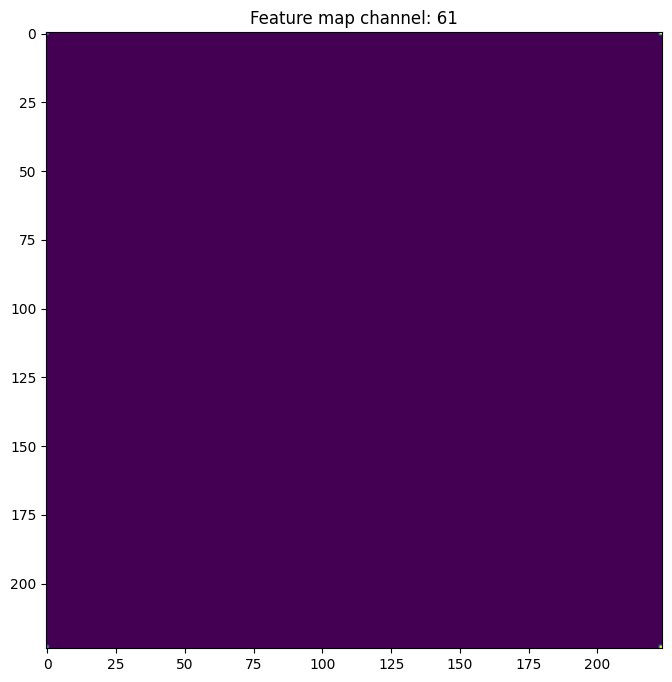

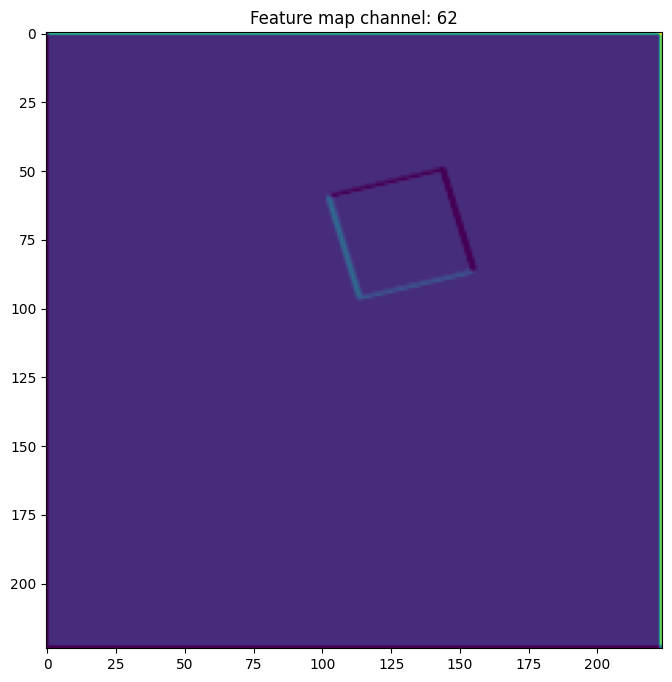

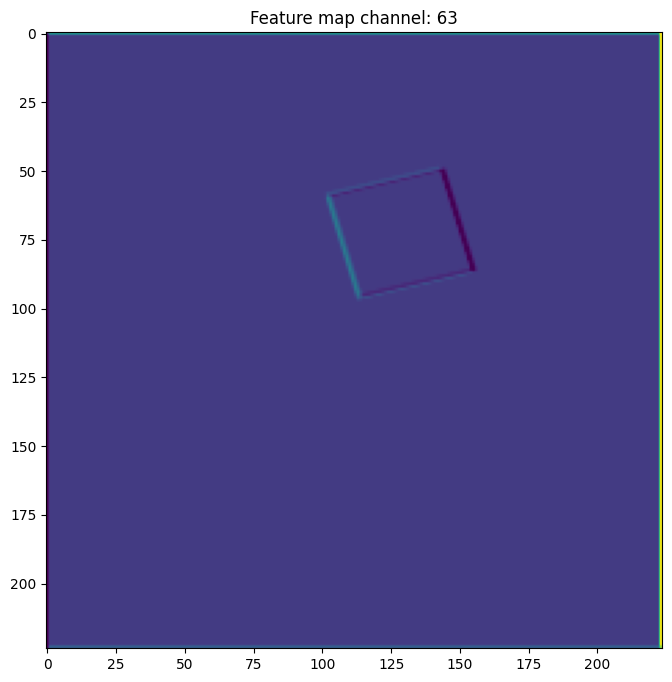

In [15]:
import matplotlib.pyplot as plt

# Define a new model that outputs the feature maps for the first convolutional layer
layer_outputs = [layer.output for layer in base_model.layers if 'conv' in layer.name]  # Grab all the convolutional layers
feature_map_model = keras.models.Model(inputs=base_model.input, outputs=layer_outputs)

# Predict on an image to get the feature maps
img = train_generator[6][0][0]  # Take the first image from the first batch of the training generator
img_tensor = np.expand_dims(img, axis=0)  # The model expects batches, so add an extra dimension
feature_maps = feature_map_model.predict(img_tensor)

# Visualize the feature maps for the first convolutional layer
num_channels = feature_maps[0].shape[-1]
for i in range(num_channels):
    plt.figure(figsize=(8, 8))
    plt.imshow(feature_maps[0][0, :, :, i], cmap='viridis')
    plt.title(f"Feature map channel: {i}")
    plt.show()

